# Features analysis

### My goal is to predict airbnb appartment price, before using ML algorithms I want to analyse features I have

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import re
from matplotlib import style
style.use('fivethirtyeight')
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [2]:
data = pd.read_csv('AB_NYC_2019.csv',parse_dates=['last_review'])
#we need shorter name for neighbourhood group for desplaying graphs
data = data.rename(columns={'neighbourhood_group': "nghbrhd"})
print(data.shape)
data.head()

(48895, 16)


,id,name,host_id,host_name,nghbrhd,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
print('Theese columns have nan values:')
print(data.isna().sum()[data.isna().sum()!=0])

Theese columns have nan values:
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


In [4]:
print(pd.unique(data.room_type),'- {} room types'.format(len(pd.unique(data.room_type))))
print(pd.unique(data.nghbrhd),'- {} neighbourhoods'.format(len(pd.unique(data.nghbrhd))))

['Private room' 'Entire home/apt' 'Shared room'] - 3 room types
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx'] - 5 neighbourhoods


/home/anna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


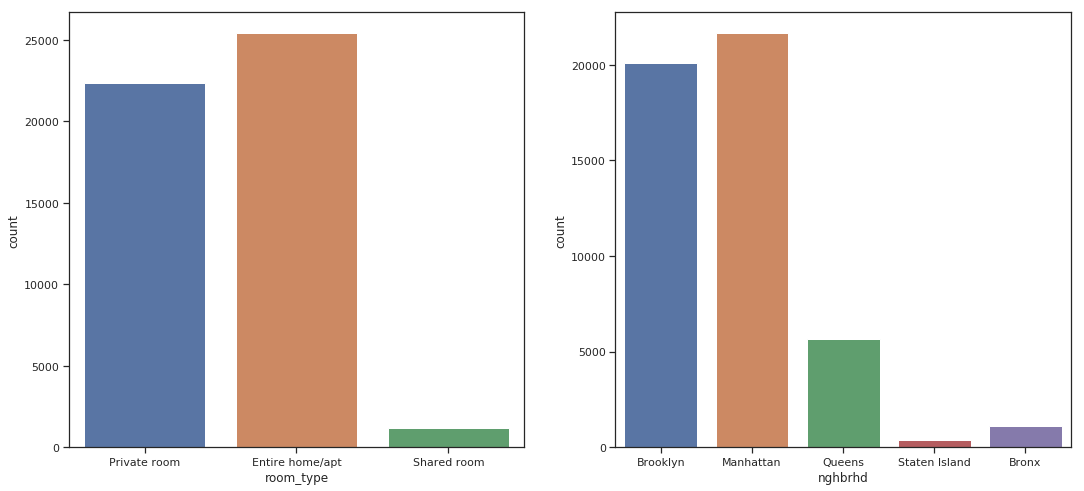

In [5]:
f, axes = plt.subplots(1, 2,figsize=(16,8))
sns.countplot(data["room_type"],ax=axes[0])
sns.countplot(data["nghbrhd"],ax=axes[1])
f.show()

### Price

In [6]:
print("There are {} appartments with price 0. We'll delete them".format(data[data.price==0]['id'].count()))

There are 11 appartments with price 0. We'll delete them


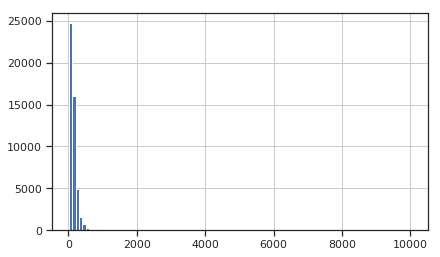

In [7]:
data = data[data['price']!=0]
data['price'].hist(bins=100)

In [8]:
Private_room_df = data[data['room_type']=='Private room']
Entire_home_apt_df = data[data['room_type']=='Entire home/apt']
Shared_room_df = data[data['room_type']=='Shared room']
Private_room_df_95 = Private_room_df['price']<Private_room_df['price'].quantile(.95)
Entire_home_apt_df_95 = Entire_home_apt_df['price']<Entire_home_apt_df['price'].quantile(.95)
Shared_room_df_95 = Shared_room_df['price']<Shared_room_df['price'].quantile(.95)
data = pd.concat([Private_room_df[Private_room_df_95],Entire_home_apt_df[Entire_home_apt_df_95],Shared_room_df[Shared_room_df_95]])

print(data.shape)

(46241, 16)


/home/anna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


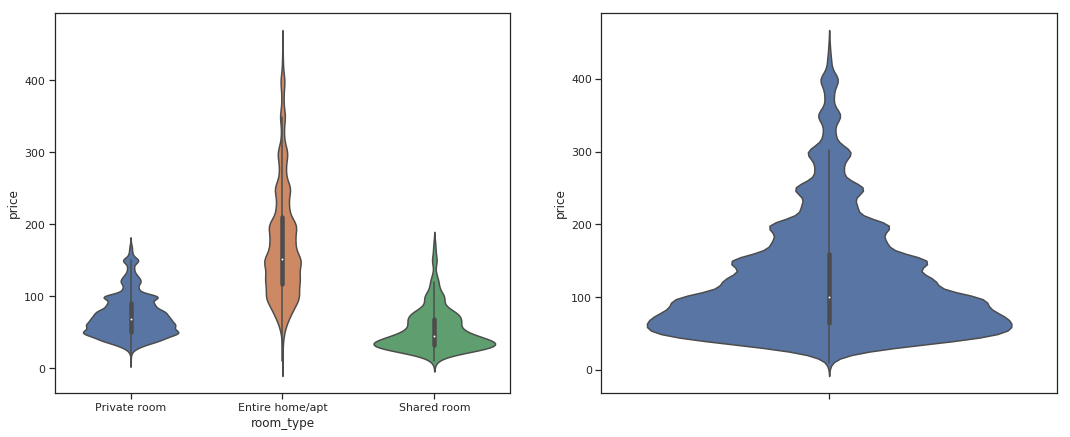

In [9]:
f, axes = plt.subplots(1, 2,figsize=(16,7))
sns.violinplot(x="room_type", y="price", data=data,ax=axes[0])
sns.violinplot(x=data["price"],orient='v',ax=axes[1])

### Host name

In [10]:
data['host_name'].head()

0         John
2    Elisabeth
6        Garon
7     Shunichi
8    MaryEllen
Name: host_name, dtype: object

In [11]:
name_gender = pd.read_csv('name_gender.csv')
name_gender['name'] = name_gender['name'].apply(lambda word: word.lower())
print(name_gender.shape)

name_gender[['F','M']] = pd.get_dummies(name_gender['gender'])
name_gender['M']=name_gender['M']*name_gender['probability']
name_gender['F']=name_gender['F']*name_gender['probability']
name_gender.set_index('name',inplace=True)
print(name_gender.head())

(95026, 3)
          gender  probability    F    M
name                                   
aaban          M          1.0  0.0  1.0
aabha          F          1.0  1.0  0.0
aabid          M          1.0  0.0  1.0
aabriella      F          1.0  1.0  0.0
aada           F          1.0  1.0  0.0


In [12]:
data.host_name=data.host_name.astype(str)
data['host_name'] = data['host_name'].apply(lambda x: re.sub(r'[.]*','',x))

data['host_name'] = data['host_name'].apply(lambda x: re.sub(r"[^a-zA-Z0-9'&]+",' ',x))
from nltk import word_tokenize
data['host_name'] = data['host_name'].apply(lambda x: word_tokenize(x))
data['host_name'] = data['host_name'].apply(lambda x: [word.lower() if word.isupper() else word for word in x])
import more_itertools as mit
data['host_name'] = data['host_name'].apply(lambda x: [[ "".join(i) for i in mit.split_before(word, pred=lambda s: s.isupper())] for word in x])
data['host_name'] = data['host_name'].apply(lambda x: [j for i in x for j in i])
data['host_name'] = data['host_name'].apply(lambda x: [word.lower()for word in x])
data['host_name'] = data['host_name'].apply(lambda x: [word.strip()for word in x])

In [13]:
#here i used some statements to see the column closser, more than 3, or ==2, for example:
for i in range(data.shape[0]):
    if len(data['host_name'].iloc[i])==4:
        print(data['host_name'].iloc[i],len(data['host_name'].iloc[i]))

['welcome', 'to', 'my', 'place'] 4
['elizabeth', 'and', 'jeff', 'too'] 4
['porfirio', 'firo', '&', 'maria'] 4
['paul', '&', 'mar', 'al'] 4
['rossy', 'carmen', 'and', 'juan'] 4
['lisa', 'nancy', '&', 'john'] 4
['rossy', 'carmen', 'and', 'juan'] 4
['rossy', 'carmen', 'and', 'juan'] 4
['hans', 'sandra', '&', 'son'] 4
['hans', 'sandra', '&', 'son'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['keiko', 'harumi', '&', 'eric'] 4
['isaac', 'linda', '&', 'noelia'] 4
['sidewalksof', 'r', 'i', 'o'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['email', 'hidden', 'by', 'airbnb'] 4
['john', "'", 'lance', "'"] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['brooklyn', '&', 'breakfast', 'len'] 4
['juan', 'pablo', '&', 'andrea'] 4
['in

In [14]:
data_host_type = pd.Series(index=data.index)
for i in range(data.shape[0]):
    host = data['host_name'].iloc[i]
    L = len(host)
    if '&' in host or 'or' in host or 'and' in host:
        data_host_type.iloc[i]='many'
    else:
        l=0
        while l<L:
            name = host[l]
            if name in name_gender.index: 
                if round(name_gender.loc[name]['F'])==1:
                    data_host_type.iloc[i]='F'
                else:
                    data_host_type.iloc[i]='M'
                break
            l+=1
data['host_type'] = data_host_type

In [15]:
data['host_type'].fillna('undefined',inplace=True)
data[['host_name','host_type']].head(20)

,host_name,host_type
0,[john],M
2,[elisabeth],F
6,[garon],M
7,[shunichi],undefined
8,"[mary, ellen]",F
11,[kate],F
12,[laurie],F
13,[claudio],M
17,[doti],undefined
21,[lisel],F


In [16]:
print('%.0f percent of host type is undefined'%(data[data['host_type']=='undefined'].count()['id']*100/data.shape[0]))

10 percent of host type is undefined


/home/anna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


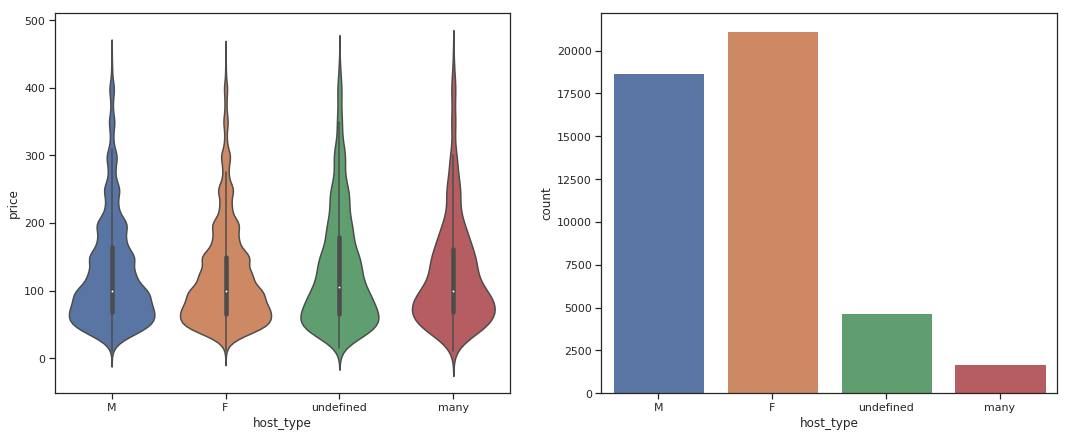

In [17]:
f, axes = plt.subplots(1, 2,figsize=(16,7))
sns.countplot(x=data["host_type"])
sns.violinplot(x="host_type", y="price", data=data,ax=axes[0])

In [18]:
def describe_feature(feature):
    plt.scatter(data[feature],data['price'],s=3)
    plt.xlabel(feature)
    plt.ylabel('price')
    plt.legend()
    plt.show()
    
    g = sns.FacetGrid(data, row='room_type',col="nghbrhd",margin_titles=True)
    g.map(plt.scatter, feature, "price", s=35, alpha=.7, linewidth=.7, edgecolor="white")
    g.add_legend()
    g.fig.subplots_adjust(wspace=.5, hspace=.5)
    plt.show()
    
    sns.violinplot(x=data[feature],orient='v')
    plt.show()
    print(data[feature].describe())

### Reviews

In [19]:
print('Theese columns have nan values:')
print(data.isna().sum()[data.isna().sum()!=0])

Theese columns have nan values:
name                   16
last_review          9064
reviews_per_month    9064
dtype: int64


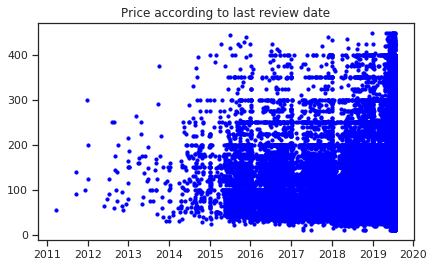

In [20]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
to_fill = data['last_review'].max()+datetime.timedelta(days=10)
data['last_review'].fillna(to_fill,inplace=True)

data = data.assign(day_last_review=data.last_review.dt.day,
                  month_last_review=data.last_review.dt.month,
                  year_last_review=data.last_review.dt.year)
plt.scatter(data['last_review'], data['price'],s=10,c ='blue')
plt.title('Price according to last review date')
plt.show()

In [21]:
data['last_review_scale'] = (data['last_review'].max()-data['last_review']).dt.days

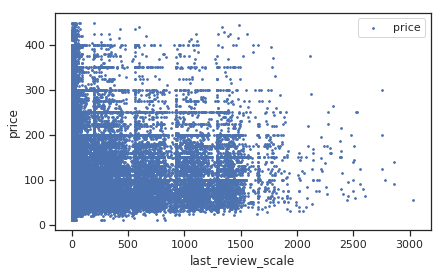

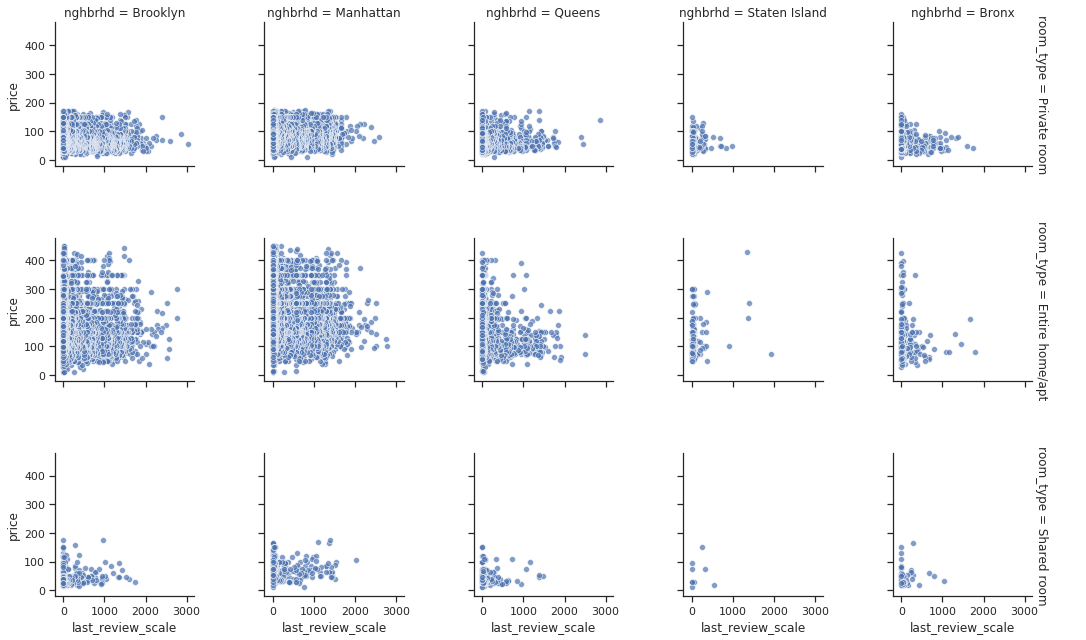

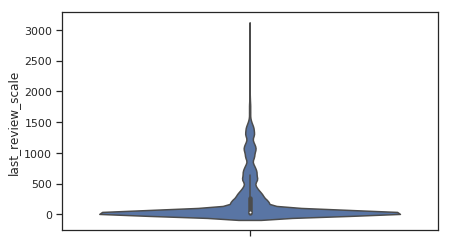

count    46241.000000
mean       230.845159
std        387.497155
min          0.000000
25%         15.000000
50%         36.000000
75%        263.000000
max       3034.000000
Name: last_review_scale, dtype: float64


In [22]:
describe_feature('last_review_scale')

In [23]:
# get rid of NaN values, replasing last_review date with the lates date and reviewes per month whith 0
data['reviews_per_month'].fillna(0,inplace=True)
print('Theese columns have nan values:')
print(data.isna().sum()[data.isna().sum()!=0])

Theese columns have nan values:
name    16
dtype: int64


### More reviwes

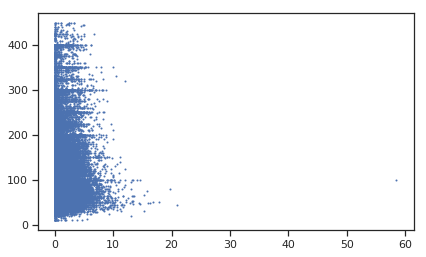

In [24]:
plt.scatter(data['reviews_per_month'],data['price'],s=1)

In [25]:
data['reviews_per_month']=[i if i<20 else 20 for i in data['reviews_per_month']]

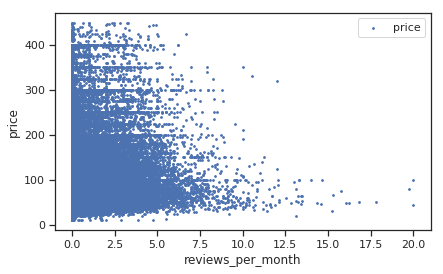

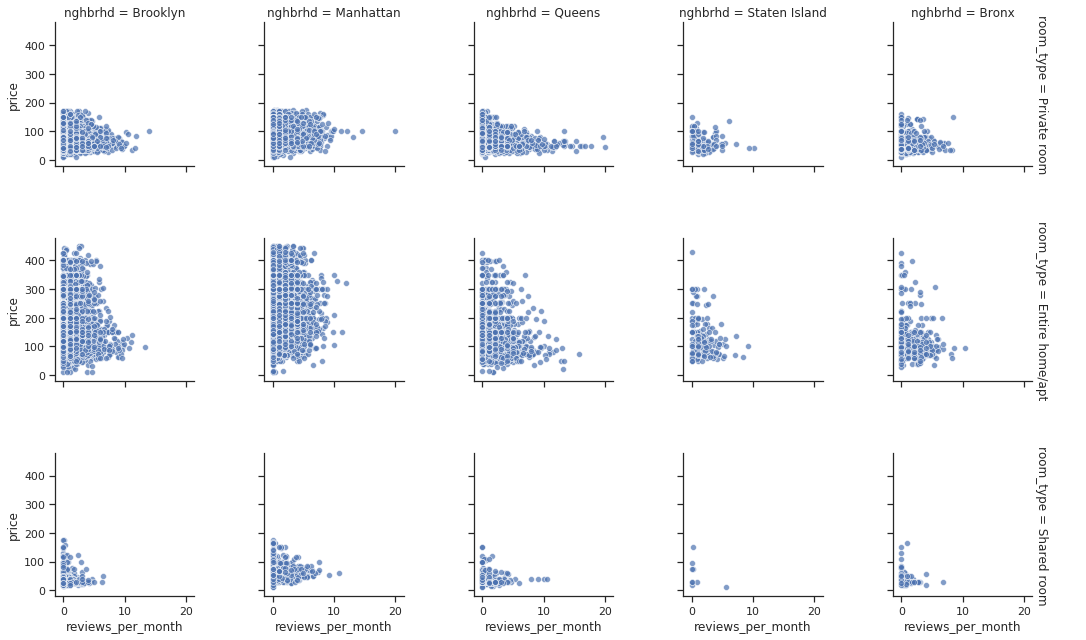

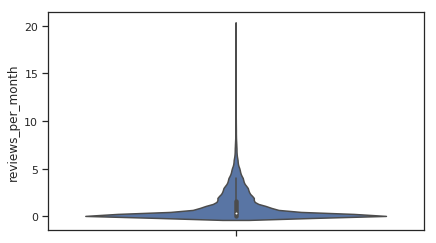

count    46241.000000
mean         1.109092
std          1.587129
min          0.000000
25%          0.050000
50%          0.390000
75%          1.630000
max         20.000000
Name: reviews_per_month, dtype: float64


In [26]:
describe_feature('reviews_per_month')

In [27]:
data['month']=data['number_of_reviews']/data['reviews_per_month']
data['month'].fillna(0,inplace=True)

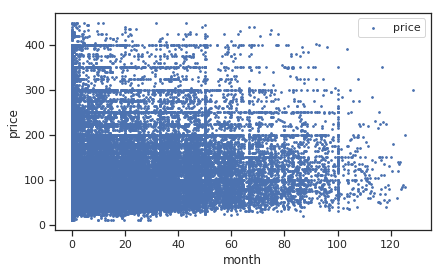

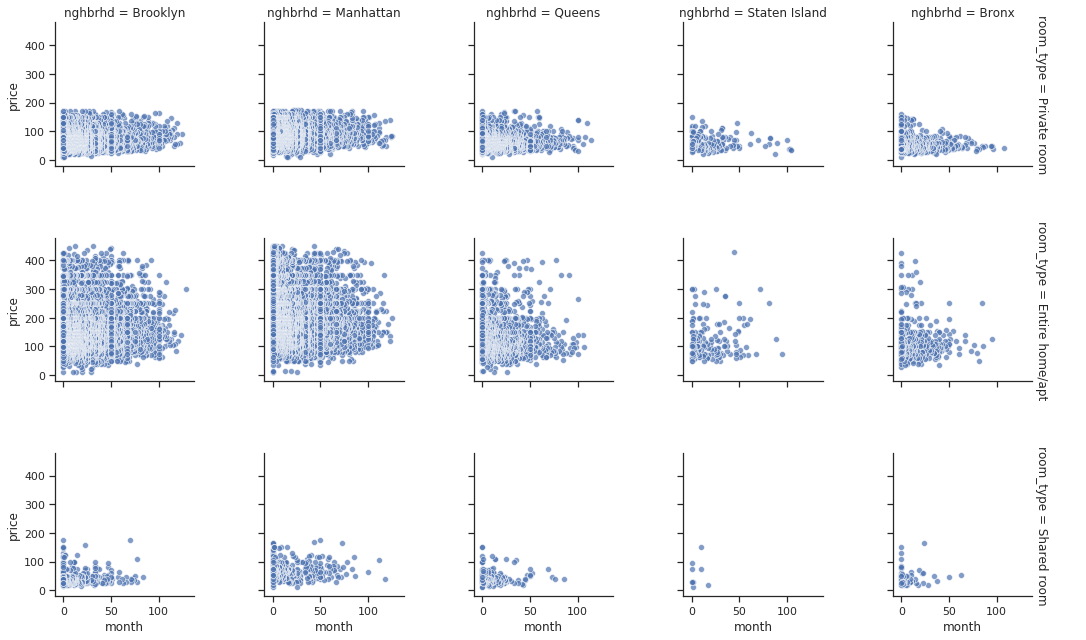

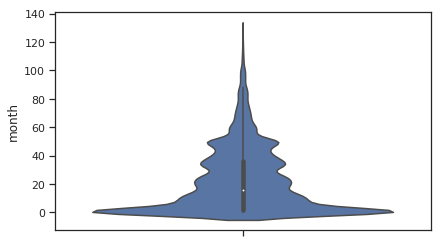

count    46241.000000
mean        22.276943
std         22.795039
min          0.000000
25%          1.801802
50%         15.555556
75%         36.363636
max        128.571429
Name: month, dtype: float64


In [28]:
describe_feature('month')

### Host_id

In [29]:
host_id_group = data.groupby('host_id').count()
owners = host_id_group[host_id_group['id']>1]['id'].index
print(owners)
print(host_id_group[host_id_group['id']>50]['id'])
owners_above_50 = host_id_group[host_id_group['id']>50]['id'].index

Int64Index([     2787,      2845,      2881,      3647,      3867,      4396,
                 7351,      7549,      9744,     10135,
            ...
            271844440, 271885652, 272127488, 272265577, 272267421, 272342845,
            272477673, 273354185, 273392981, 274012871],
           dtype='int64', name='host_id', length=4874)
host_id
1475015       52
7503643       52
12243051      96
16098958      94
22541573      87
30283594     114
61391963      91
107434423    227
137358866    103
200380610     58
219517861    289
Name: id, dtype: int64


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text xticklabel objects>)

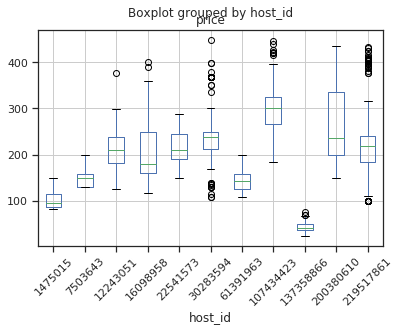

In [30]:
data.set_index('host_id').loc[owners_above_50].boxplot(column='price',by='host_id')
plt.xticks(rotation=45)

In [31]:
print('%.1f percent appartments are hosted by someone who posted more than 50 appartments'%((data[data['calculated_host_listings_count']>50]['id'].count()/data.shape[0])*100))

2.7 percent appartments are hosted by someone who posted more than 50 appartments


In [32]:
mean_owners = []
data_mean_owner = pd.Series(index=data.index)
for i in owners:
    mean_ = data[data['host_id']==i]['price'].mean()
    data_mean_owner[data['host_id']==i] = mean_
    mean_owners.append(mean_)

<a list of 50 Patch objects>

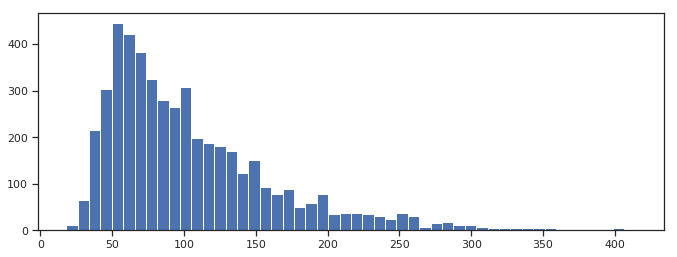

In [33]:
plt.figure(figsize=(10,4))
plt.hist((mean_owners),bins=50)[2]

In [34]:
data['mean_owner']=data_mean_owner
data['mean_owner'].fillna(0,inplace=True)

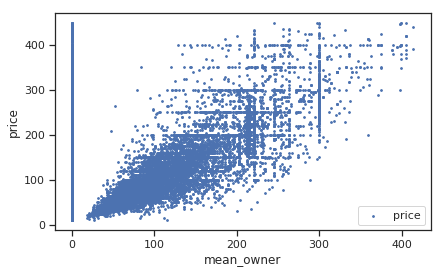

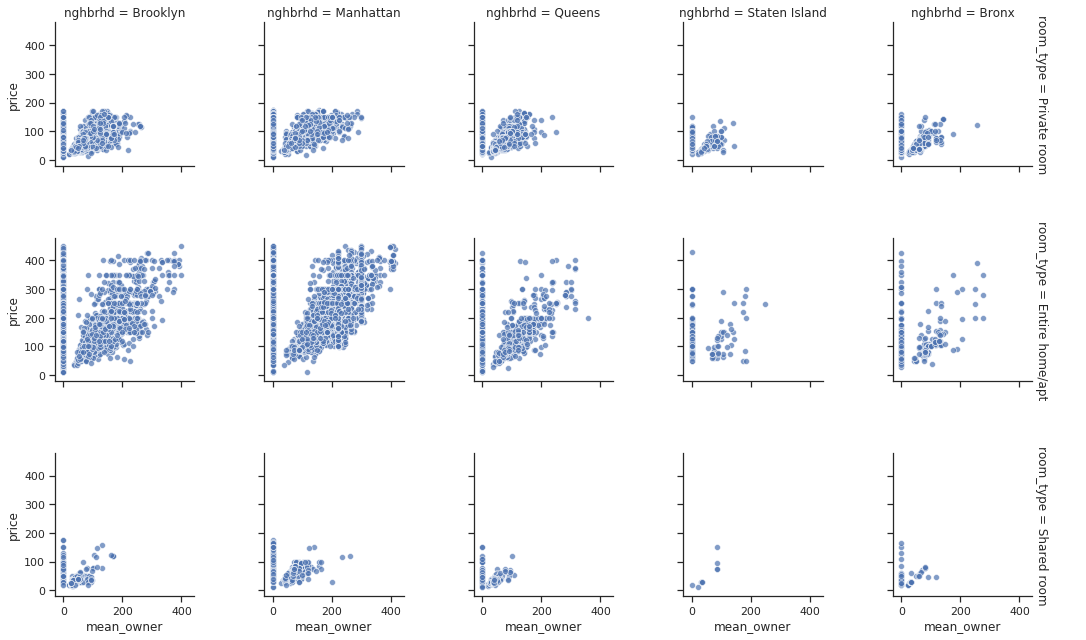

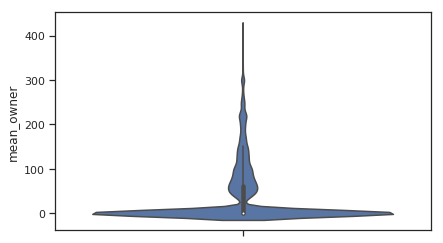

count    46241.000000
mean        37.617504
std         66.092657
min          0.000000
25%          0.000000
50%          0.000000
75%         60.000000
max        414.500000
Name: mean_owner, dtype: float64


In [35]:
describe_feature('mean_owner')

### Calculated host listings count

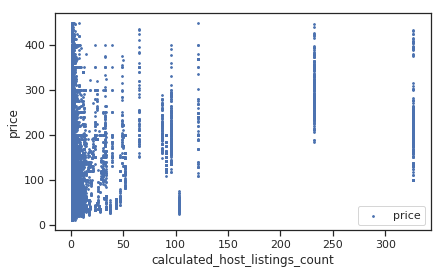

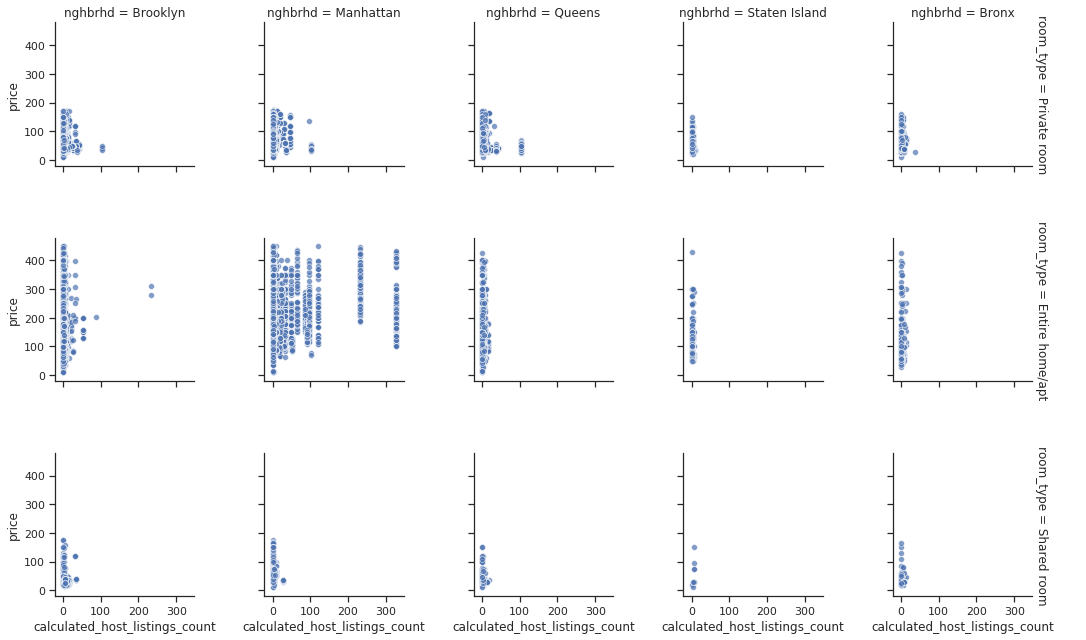

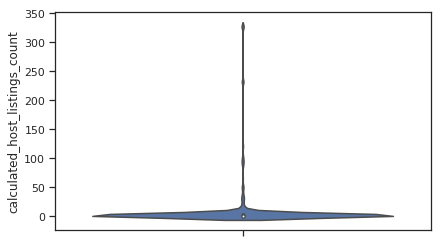

count    46241.000000
mean         7.013884
std         32.427529
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64


In [36]:
describe_feature('calculated_host_listings_count')

### Minimum nights

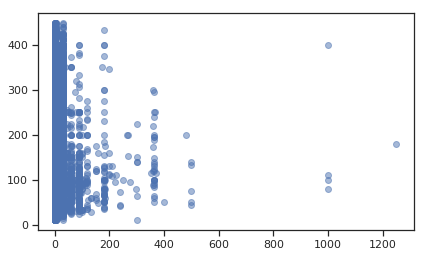

In [37]:
plt.scatter(data['minimum_nights'],data['price'],alpha=0.5)

In [38]:
data['minimum_nights']=[i if i<500 else 500 for i in data.minimum_nights]

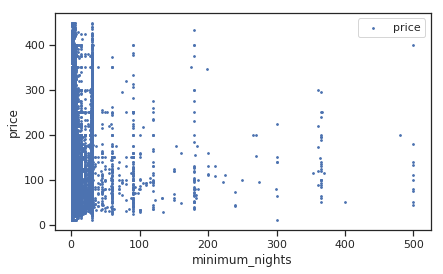

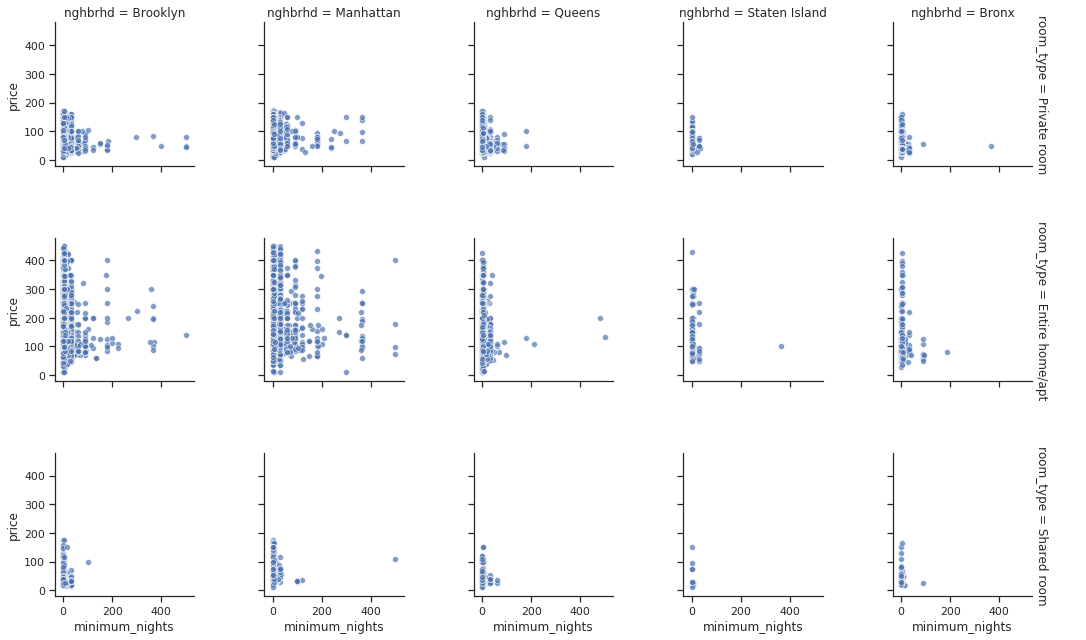

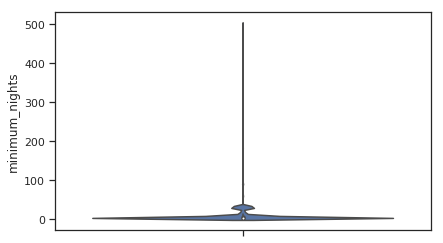

count    46241.000000
mean         6.991869
std         17.994049
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        500.000000
Name: minimum_nights, dtype: float64


In [39]:
describe_feature('minimum_nights')

### Availability 365

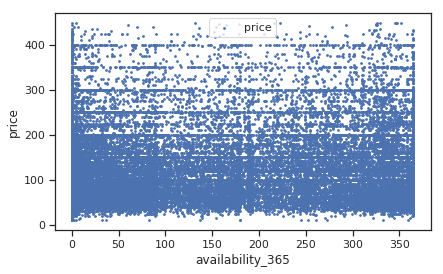

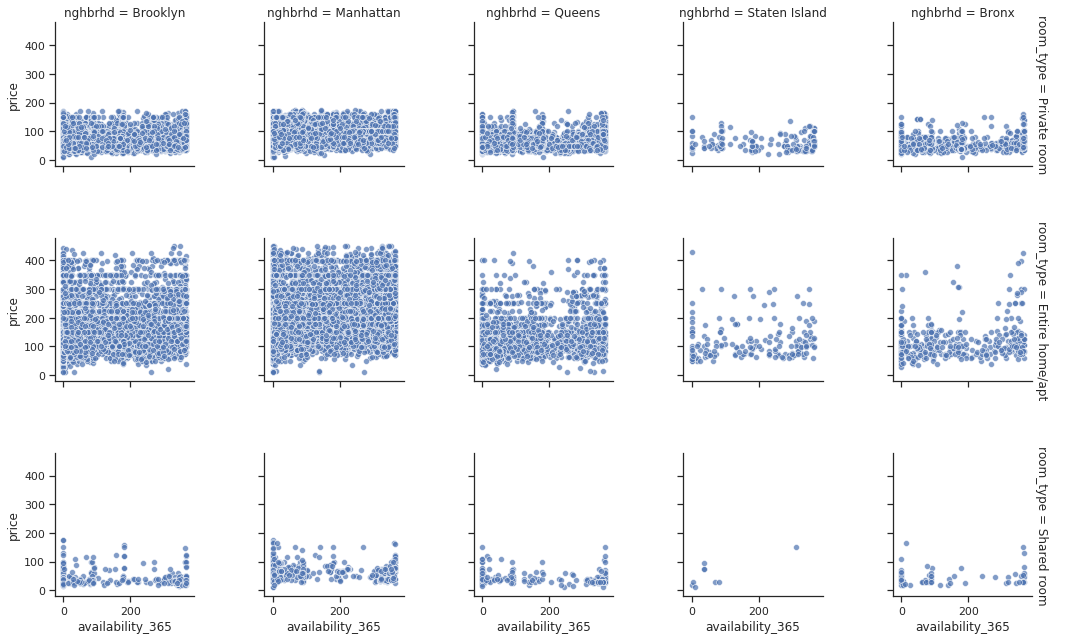

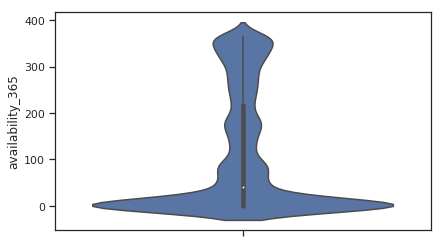

count    46241.000000
mean       109.681495
std        130.244542
min          0.000000
25%          0.000000
50%         40.000000
75%        218.000000
max        365.000000
Name: availability_365, dtype: float64


In [40]:
describe_feature('availability_365')

### Correlation table 

In [41]:
corr = data[['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','last_review_scale','month','mean_owner']].corr()
corr.style.background_gradient(cmap='RdYlGn').set_precision(2)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_scale,month,mean_owner
price,1,0.041,-0.035,-0.044,0.18,0.075,-0.03,-0.00024,0.21
minimum_nights,0.041,1,-0.092,-0.14,0.15,0.17,0.0012,-0.02,0.13
number_of_reviews,-0.035,-0.092,1,0.6,-0.073,0.18,-0.19,0.46,0.038
reviews_per_month,-0.044,-0.14,0.6,1,-0.054,0.17,-0.3,-0.023,0.041
calculated_host_listings_count,0.18,0.15,-0.073,-0.054,1,0.23,-0.07,-0.12,0.46
availability_365,0.075,0.17,0.18,0.17,0.23,1,-0.27,0.04,0.35
last_review_scale,-0.03,0.0012,-0.19,-0.3,-0.07,-0.27,1,0.46,-0.14
month,-0.00024,-0.02,0.46,-0.023,-0.12,0.04,0.46,1,-0.052
mean_owner,0.21,0.13,0.038,0.041,0.46,0.35,-0.14,-0.052,1


### Name

In [42]:
def name_cleaning(data_name = data['name']):
    data_name=data_name.astype(str)
    #1 spliting words by uppercase letter. there are some words fully uppercase, we need to first lowercase them to not confuse with those to split
    data_name = data_name.apply(lambda x: re.sub(r"[^a-zA-Z0-9']+",' ',x))
    from nltk import word_tokenize
    data_name = data_name.apply(lambda x: word_tokenize(x))
    data_name = data_name.apply(lambda x: [word.lower() if word.isupper() else word for word in x])

    import more_itertools as mit
    data_name = data_name.apply(lambda x: [[ "".join(i) for i in mit.split_before(word, pred=lambda s: s.isupper())] for word in x])
    data_name = data_name.apply(lambda x: [[ "".join(i) for i in mit.split_before(word, pred=lambda s: s.isdigit())] for word in x])
    data_name = data_name.apply(lambda x: [j for i in x for j in i])
    data_name = data_name.apply(lambda x: [word.lower()for word in x])

    data_name = data_name.apply(lambda x: [re.split(r'(\d+)', word) for word in x])
    data_name = data_name.apply(lambda x: [j for i in x for j in i])

    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    data_name = data_name.apply(lambda x: [word for word in x if word not in stop_words])
    data_name = data_name.apply(lambda x: [word for word in x if word !=''])

    from nltk.stem import WordNetLemmatizer
    lem = WordNetLemmatizer()
    data_name = data_name.apply(lambda x: [lem.lemmatize(word,'v') for word in x])
    from nltk.stem import PorterStemmer 
    ps = PorterStemmer()
    data_name = data_name.apply(lambda x: [ps.stem(word) for word in x])

    data_name = data_name.apply(lambda x: [re.sub(r'^ap+[artm]+.*','apt',word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^ro*m','rm',word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^lux.*','lux', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^light.*','light', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^be*d[rm].*','bd', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^ba*th.*','bth', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^b[kr]o*[kl].*','brooklyn', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^ma*nht+a*n','manhattan', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^rail.*','train', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^sun.*','sun', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^styl.*','style', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^subw.*','sub', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^up[twnper]*.*','uptwn', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^n[eigh]*b+[hod]*.*','nb', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^b[eau]*t+.*','beaut', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^w[ilia]*[nmsb]+.+','wlmsbrg', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^.*hous.*','house', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^minut','min', word) for word in x])
    data_name = data_name.apply(lambda x: [re.sub(r'^sq[uf].*','sq', word) for word in x])

    for apt in data_name:
        for i in range(len(apt)-1):
            if apt[i].isdigit():
                apt[i] = apt[i]+apt[i+1]
    data_name = data_name.apply(lambda x: [word for word in x if not word.isdigit()])
    data_name = data_name.apply(lambda x: ' '.join(x))
    return data_name
data['name'] = name_cleaning(data['name'])
print(data['name'].head())

0         clean quiet apt home park
2            villag harlem new york
6                     blissartsspac
7        larg furnish rm near b'way
8    cozi clean guest rm famili apt
Name: name, dtype: object


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(max_df = 0.1,min_df=0.00003)
features_name = count.fit_transform(data['name'])
print('We distinquished {} words and number_words'.format(features_name.shape[1]))
print(type(features_name))

words_df = pd.DataFrame(features_name.toarray(), columns=count.get_feature_names())
X_all_words = words_df.to_numpy()
print(words_df.columns[:10],words_df.columns[3000:3010],words_df.columns[-10:])

We distinquished 2952 words and number_words
<class 'scipy.sparse.csr.csr_matrix'>
Index(['000sf', '000sq', '0min', '1000sq', '100night', '100privat', '105th',
       '108th', '10day', '10foot'],
      dtype='object') Index([], dtype='object') Index(['yorkvil', 'young', 'youth', 'yr', 'yurt', 'zen', 'zimmer', 'zona',
       'zone', 'zoo'],
      dtype='object')


In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def get_wordcloud(text_data,title):
  wordcloud = WordCloud(background_color='black',
                        stopwords=set(STOPWORDS),
                        max_font_size=40, 
                        relative_scaling=1.0,
                        random_state=1
  ).generate(str(text_data))

  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')
  plt.title(title)
  plt.imshow(wordcloud)
  plt.show()

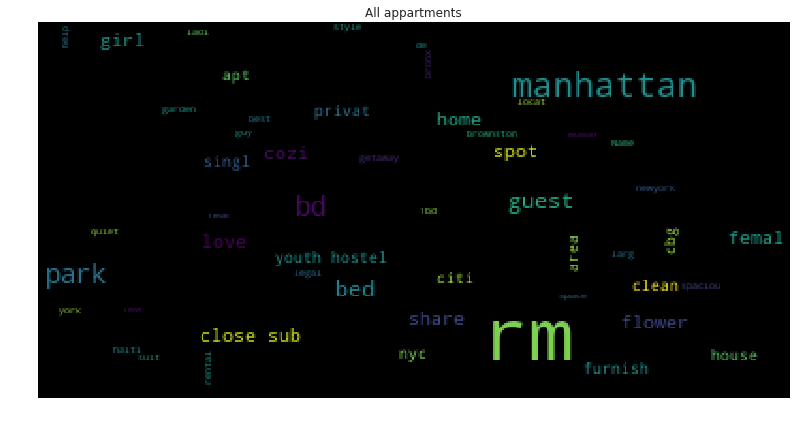

In [45]:
get_wordcloud(data['name'],'All appartments')

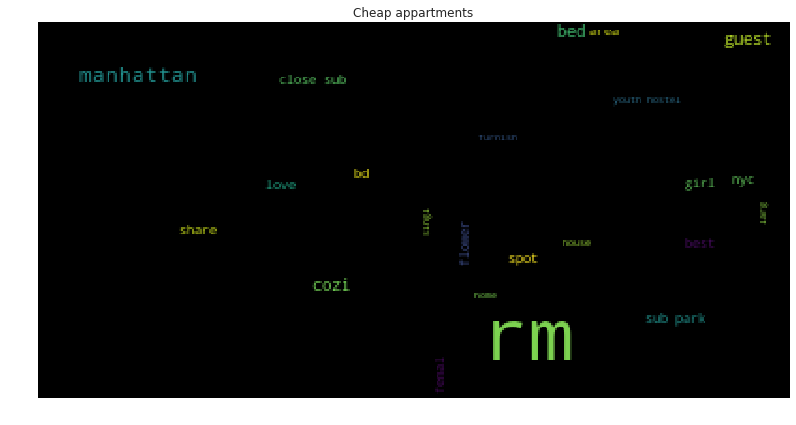

In [46]:
cheap_ap = data.loc[(data['price']<=100)]['name']
get_wordcloud(cheap_ap,'Cheap appartments')

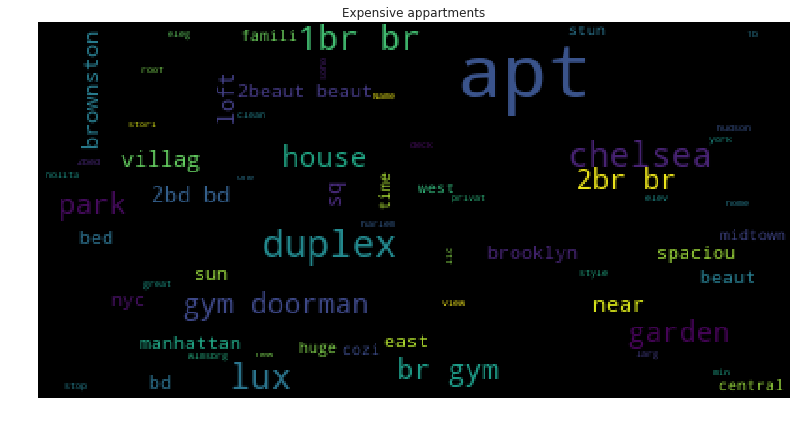

In [47]:
exp_ap = data.loc[(data['price']>=300)]['name']
get_wordcloud(exp_ap,'Expensive appartments')

## All together

In [50]:
data.rename(columns={"nghbrhd":'neighbourhood_group'},inplace=True)
filtered_df = data[['price','name','neighbourhood_group','room_type','minimum_nights','last_review','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','host_id']]
pickle.dump(filtered_df, open('filtered_df','wb'))

In [49]:
def data_transformer(df = data_train,train_df = data_train):
    X_df = df
    for categorical_variable in ['room_type','neighbourhood_group']:
        X_df = pd.concat([X_df,pd.get_dummies(df[categorical_variable])],axis=1)
        X_df.drop(columns=[categorical_variable],inplace=True)
    to_fill = df['last_review'].max()+datetime.timedelta(days=10)
    df['last_review'].fillna(to_fill,inplace=True)
    X_df['last_review_scale'] = (df['last_review'].max()-df['last_review']).dt.days
    X_df.drop(columns=['last_review'],inplace=True)
    
    X_df['reviews_per_month'].apply(lambda i: i if i<20 else 20)
    
    X_df['month']=df['number_of_reviews']/df['reviews_per_month']
    X_df['month'].fillna(0,inplace=True)
    
    X_df['minimum_nights'].apply(lambda i: i if i<500 else 500)
    
    X_df['data_mean_owner'] = pd.Series(index=X_df.index)
    host_id = list(X_df[X_df['calculated_host_listings_count']>1]['host_id'])
    for i in host_id:
        mean_ = train_df[train_df['host_id']==i]['price'].mean()
        I = X_df[X_df['host_id']==i].index
        X_df.loc[I,'data_mean_owner'] = mean_
    X_df['data_mean_owner'].fillna(0,inplace=True)
    X_df.drop(columns=['host_id'])
    return X_df